## Kaggle Materialization Experiment
In this notebook, we make the plot in Figure 5 and 6 of Section 6.3.

Experiment result is located here:

'./experiment_results/remote/materialization/kaggle_home_credit/cloud-41/2019-10-19/21-12.csv'


In [1]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import os
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_style({'grid.color': '.5'})
plt.rc('hatch', color='white', linewidth=1)
plt.use('pgf')

FONT_SIZE = 25
LW=4
plt.rcParams.update({
    "lines.markersize": 20,
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,   
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": FONT_SIZE,     
    "font.size": FONT_SIZE,
    "legend.fontsize": FONT_SIZE, 
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    #"figure.figsize": figsize(1.0), 
     "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
})
#plt.rc('hatch', color='white', linewidth=LW)
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results/remote'


SYSTEM_COLOR = sns.color_palette()[0]
BASELINE_COLOR = sns.color_palette()[1]
HELIX_COLOR = sns.color_palette()[2]
ALL_COLOR = sns.color_palette()[3]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/slides/assets'

output_directory = WRITE_DIRECTORY_ROOT + '/experiment-results'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def savefig(filename):
    plt.savefig('{}.pgf'.format(filename), bbox_inches='tight')
    plt.savefig('{}.pdf'.format(filename), bbox_inches='tight')

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/Cellar/python@2/2.7.16_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python@2/2.7.16_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lo

In [2]:
result_folder = ROOT_RESULT_FOLDER + '/materialization/kaggle_home_credit'
result_file = result_folder + '/cloud-41/2020-02-03/21-14.csv'

In [4]:
HM = 'Collab-mat'
SA = 'Storage-aware'
ALL = 'All-materializer'
HL = 'Helix'
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'workload', 'mat_type','budget', 'total_mat', 'total_size','run_time'
]
mat_map = {'simple':HM,'storage_aware':SA, 'all':ALL, 'helix':HL}
materialization_result = pd.read_csv(result_file, header=None, names=HEADERS)
materialization_result['mat_type'] = materialization_result['mat_type'].replace(mat_map)
materialization_result[['budget', 'total_mat', 'total_size']] = materialization_result[['budget', 'total_mat', 'total_size']] / (1024 * 1024)
materialization_result['budget'] = materialization_result['budget'].astype(int)
execution_order = {
    'start_here_a_gentle_introduction': 1,
    'introduction_to_manual_feature_engineering': 2,
    'introduction_to_manual_feature_engineering_p2': 3,
    'fork_cridata_start_here_a_gentle_introduction': 4,
    'fork_taozhongxiao_start_here_a_gentle_introduction': 5,
    'fork_introduction_to_manual_feature_engineering': 6,
    'fork_introduction_to_manual_feature_engineering_p2': 7,
    'fork_join_start_here_intro': 8
}
materialization_result['workload_order'] = materialization_result['workload'].replace(execution_order)
materialization_result = materialization_result[materialization_result.budget!=0]
materialization_result['cumulative_run_time'] = materialization_result.groupby(
    ['exp_id', 'mat_type','budget'])['run_time'].apply(lambda x: x.cumsum())

In [5]:
def plot_execution_time(df, ax, loc=None):
    cat_df = df[df.mat_type != ALL]
    cat = sns.barplot(
        data=cat_df,
        x='budget',
        y='run_time',
        hue='mat_type',
        ax=ax,
        errwidth=3,
        errcolor='0',
        ci='sd',
        hue_order=[SA, HM, HL],
        palette={
            SA: SYSTEM_COLOR,
            HM: BASELINE_COLOR,
            HL: HELIX_COLOR
        })
    cat.set_xlabel('Budget (GB)')
    cat.set_ylabel('Run Time (s)')
    all_mat_cost = df[df.mat_type == ALL].run_time.values[0]
    ax.axhline(all_mat_cost, dashes=(2, 1), linewidth=5, color=ALL_COLOR)
    ax.set(xlim=(-0.6, 3.6))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))
    cat.tick_params(axis='both', which='major', pad=-2)
    budgets = len(df.budget.unique()) - 1
    for i, bar in enumerate(ax.patches):
        if i < budgets:
            h = '/'
        elif i < 2*budgets:
            h = 'X'
        else:
            h = 'O'
        bar.set_edgecolor('black')
        bar.set_hatch(h)
    cat.get_legend().remove()
    from matplotlib.lines import Line2D
    lg = plt.legend()
    handles = lg.legendHandles
    labels = [SA, HM, HL, ALL]

    handles.append(
        Line2D([0], [1], color=ALL_COLOR, linewidth=5, dashes=(2, 1)))

    lg = plt.legend(
        handles,
        labels,
        frameon=True,
        borderpad=0.2,
        loc='upper center',
        handlelength=1.8,
        handletextpad=0.1,
        #fontsize=22,
        ncol=2,
        columnspacing=0.5,
        bbox_to_anchor=(.50, 1.35))
    lg.get_frame().set_edgecolor('black')
    lg.get_frame().set_linewidth(2.0)

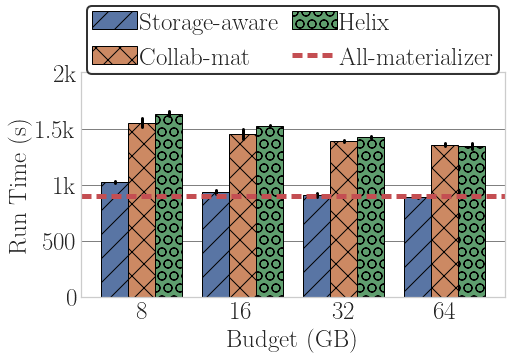

In [6]:
materialization_result['mat_type_budget'] = materialization_result['mat_type'] + materialization_result['budget'].apply(lambda s:'-'+str(s))
df_speedup = materialization_result[materialization_result.budget<32]
df_speedup = df_speedup[df_speedup.mat_type!=HM]
df_total_runtime = materialization_result.groupby(['exp_id','mat_type','budget'])['run_time'].sum().reset_index()
plt.clf()
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
plot_execution_time(df_total_runtime, ax)

plt.tight_layout(pad=0,h_pad=0,w_pad=0)
savefig(output_directory+'/run-time')

In [70]:
materialization_result['mat_type_budget'] = materialization_result['mat_type'] + materialization_result['budget'].apply(lambda s:'-'+str(s))
df_speedup = materialization_result[materialization_result.budget>=32]

In [18]:
df_speedup[df_speedup.mat_type=='HL']

,timestamp,exp_id,repo,workload,mat_type,budget,total_mat,total_size,run_time,workload_order,cumulative_run_time,KG,speedup,mat_type_budget
264,00:51:13,EBD3EA34,kaggle_home_credit,start_here_a_gentle_introduction,HL,32,13.692511,13.692511,202.009310,1,202.009310,192.731235,0.954071,HL-32
265,00:51:13,EBD3EA34,kaggle_home_credit,introduction_to_manual_feature_engineering,HL,32,32.454355,38.118095,174.223353,2,376.232663,396.933902,1.055022,HL-32
266,00:51:13,EBD3EA34,kaggle_home_credit,introduction_to_manual_feature_engineering_p2,HL,32,34.300480,121.095739,301.288817,3,677.521480,757.972342,1.118743,HL-32
267,00:51:13,EBD3EA34,kaggle_home_credit,fork_cridata_start_here_a_gentle_introduction,HL,32,34.300480,128.595869,170.610892,4,848.132372,918.129079,1.082530,HL-32
268,00:51:13,EBD3EA34,kaggle_home_credit,fork_taozhongxiao_start_here_a_gentle_introduc...,HL,32,34.300480,134.253921,94.660460,5,942.792832,1028.806120,1.091232,HL-32
269,00:51:13,EBD3EA34,kaggle_home_credit,fork_introduction_to_manual_feature_engineering,HL,32,37.146363,134.257123,147.894461,6,1090.687293,1186.942219,1.088252,HL-32
270,00:51:13,EBD3EA34,kaggle_home_credit,fork_introduction_to_manual_feature_engineerin...,HL,32,34.985843,134.257123,212.055748,7,1302.743041,1536.511971,1.179444,HL-32
271,00:51:13,EBD3EA34,kaggle_home_credit,fork_join_start_here_intro,HL,32,37.307363,136.237956,131.122258,8,1433.865299,1793.155252,1.250574,HL-32
272,01:21:16,DB99FAC5,kaggle_home_credit,start_here_a_gentle_introduction,HL,32,13.692511,13.692511,201.328101,1,201.328101,192.731235,0.957299,HL-32
273,01:21:16,DB99FAC5,kaggle_home_credit,introduction_to_manual_feature_engineering,HL,32,32.454355,38.118095,172.926976,2,374.255077,396.933902,1.060597,HL-32


In [ ]:
def plot_speed_up_times(df, ax=None):
    LW=4
    plot = sns.lineplot(
        data=df,
        #ax=ax,
        x='workload_order',
        y='speedup',
        hue='budget',
        style='budget',
        hue_order=[8, 16, 32, 64,1],
        markers={
            8: "o",
            16:'X',
            32: "^",
            64: 'v',
            1:'p'
        },
        lw=LW,
        markersize=12,
        ci=None,
        dashes={
            8: (1, 0),
            16: (2, 2),
            32: (3, 1),
            64: (1, 1),
            1: (2,4)
        },
        palette={
            8:SYSTEM_COLOR,
            16:BASELINE_COLOR,
            32: HELIX_COLOR,
            64: ALL_COLOR,
            1:sns.color_palette()[4]
        },
        legend='brief')
    
    
    plot.set_xlabel('Workload\n{}'.format('\\textbf{{(b) Speedup vs KG}}'))
    plot.set_ylabel('Speedup')
    plot.set_xticks(range(1,9))
    plot.set_xticklabels(range(1,9))
    plot.set_yticks([1.0,1.5,2.0])
    plot.set_yticklabels([1.0,1.5,2.0])
    
    plot.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))
    plot.get_legend().remove()
    plot.tick_params(axis='both', which='major', pad=-2)
    
    handles = []
    labels = ['B=8', 'B=16', 'B=32', 'B=64', 'ALL']
    from matplotlib.lines import Line2D
    handles.append(Line2D([0], [1],
                        color=SYSTEM_COLOR,
                        lw=LW,
                        dashes=(1, 0),
                        marker="o",
                        markersize=15))
    handles.append(Line2D([0], [1],
                        color=BASELINE_COLOR,
                        lw=LW,
                        dashes=(2, 2),
                        marker="X",
                        markersize=15))
    handles.append(Line2D([0], [1],
                        color=HELIX_COLOR,
                        lw=LW,
                        dashes=(3, 1),
                        marker="^",
                        markersize=15))
    handles.append(Line2D([0], [1],
                        color=ALL_COLOR,
                        lw=LW,
                        dashes=(3, 1),
                        marker="v",
                        markersize=15))
    
    handles.append(Line2D([0], [1],
                        color=sns.color_palette()[4],
                        lw=LW,
                        dashes=(2, 4),
                        marker="p",
                        markersize=15))
    
    legend = plot.legend(
        handles,
        labels,
        frameon=True,
        borderpad=0.2,
        loc='upper center',
        fontsize=22,
        handlelength=1.7,
        handletextpad=0.1,
        numpoints=1,
        ncol=5,
        bbox_to_anchor=(0.77,1.27),
        columnspacing=0.5)
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(2.0)

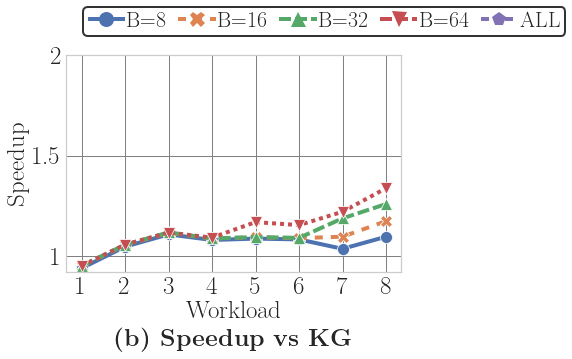

In [12]:
df_speedup = materialization_result[(materialization_result.mat_type=='HL')]
plot_speed_up_times(df_speedup)


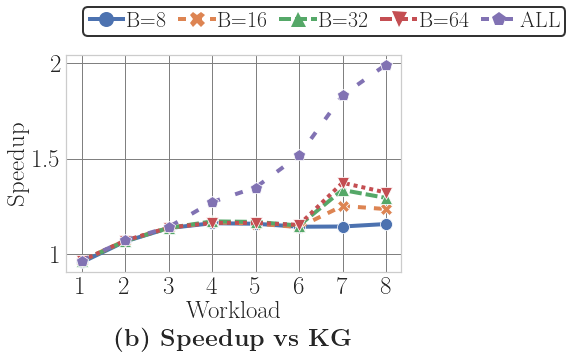

In [11]:
df_speedup = materialization_result[(materialization_result.mat_type=='ALL') | (materialization_result.mat_type=='HM')]
plot_speed_up_times(df_speedup)

In [15]:
materialization_result['mat_type_budget'] = materialization_result['mat_type'] + materialization_result['budget'].apply(lambda s:'-'+str(s))
df_speedup = materialization_result[materialization_result.budget<32]